# Project 3 — Dirichlet–Neumann Domain Decomposition
This notebook demonstrates the implementation and results of a parallel Dirichlet–Neumann (D–N) iteration
for the steady-state heat equation inside a multi-room apartment.

**Tasks covered**
| PDF task | Description |
|-----------|--------------|
| Task 1 | Build discrete Laplace matrices (Δx = 1/3) |
| Task 2 | Test if the heating system is sufficient (Δx = 1/20, K = 10, ω = 0.8) |
| Task 3 | Visualize temperature distribution |
| Task 4 | Sensitivity to parameters (ω, K, heater temp) |
| Project 3a | Extended 2.5-room apartment (5 MPI processes) |


## Environment setup

In [1]:
import os, sys, subprocess, numpy as np, matplotlib.pyplot as plt

# ---- Project path & mpiexec (Mac / Homebrew) ----
PROJECT_ROOT = ""
sys.path.append(PROJECT_ROOT)

mpiexec = "/opt/homebrew/bin/mpiexec"
# mpiexec = mpiexec
assert os.path.exists(mpiexec), "Please verify your mpiexec path!"

# Output directories
os.makedirs("output", exist_ok=True)
os.makedirs("ext_output", exist_ok=True)

## Task 1 — Matrix structure demonstration (Δx = 1/3)
* Each subdomain (room) is discretized with an interior grid of size (Nx-2) × (Ny-2).
* Dirichlet boundaries remove the boundary nodes from the unknown vector and move their contribution to **b**.
* Neumann boundaries appear as ± 1/Δx terms inside **A** and **b**.
* In the D–N iteration, Ω₂ uses Dirichlet data from interfaces Γ₁, Γ₂ while Ω₁ and Ω₃ use Neumann fluxes.

In [2]:
from common.boundary_config import get_boundary_conditions
from common.utils import get_room_grid_info, get_interface_grid_info
from core.matrix_builder import build_laplace_matrix_mixed, build_b_mixed
import numpy as np

dx = dy = 1/3

iface_info = get_interface_grid_info(dx, dy)
Ny_interface = iface_info['Ny_interface'][0]   # 与 room1/room3 的竖直接口
# 仅用于 Task 1 演示，给个占位接口；A 与这些数值无关，但 b 需要形状正确
gamma1_demo = np.zeros(Ny_interface)  # Ω1↔Ω2 的接口值（Dirichlet/Neumann 视房间而定）
gamma2_demo = np.zeros(Ny_interface)  # Ω2↔Ω3 的接口值

def demo_room_matrix(room_name):
    # 取该房间网格尺寸
    room_info = get_room_grid_info(room_name, dx, dy)
    Nx, Ny = room_info['Nx'], room_info['Ny']

    # room1 需要 gamma1（右边 Neumann），room3 需要 gamma2（左边 Neumann），
    # room2 需要 gamma1/gamma2 作为左右 Dirichlet 的接口段
    if room_name == "room1":
        bc_types, bc_values = get_boundary_conditions(room_name, gamma1_demo, None, dx=dx, dy=dy)
    elif room_name == "room2":
        bc_types, bc_values = get_boundary_conditions(room_name, gamma1_demo, gamma2_demo, dx=dx, dy=dy)
    elif room_name == "room3":
        bc_types, bc_values = get_boundary_conditions(room_name, None, gamma2_demo, dx=dx, dy=dy)
    else:
        raise ValueError("Only room1/room2/room3 in Project 3.")

    # 组装 A 与 b
    A, nx, ny = build_laplace_matrix_mixed(Nx, Ny, dx, bc_types)
    b = build_b_mixed(Nx, Ny, dx, bc_types, bc_values)

    print(f"\n[{room_name}] Δx=1/3 -> internal size = {(Nx-2)} x {(Ny-2)} -> A.shape = {A.shape}")
    print(A.toarray() if hasattr(A, "toarray") else A)
    print("b:", b)
    return A, b

A1, b1 = demo_room_matrix("room1")
A2, b2 = demo_room_matrix("room2")
A3, b3 = demo_room_matrix("room3")


[room1] Δx=1/3 -> internal size = 2 x 2 -> A.shape = (4, 4)
[[-36.   9.   9.   0.]
 [  9. -27.   0.   9.]
 [  9.   0. -36.   9.]
 [  0.   9.   9. -27.]]
b: [-495. -135. -495. -135.]

[room2] Δx=1/3 -> internal size = 2 x 5 -> A.shape = (10, 10)
[[-36.   9.   9.   0.   0.   0.   0.   0.   0.   0.]
 [  9. -36.   0.   9.   0.   0.   0.   0.   0.   0.]
 [  9.   0. -36.   9.   9.   0.   0.   0.   0.   0.]
 [  0.   9.   9. -36.   0.   9.   0.   0.   0.   0.]
 [  0.   0.   9.   0. -36.   9.   9.   0.   0.   0.]
 [  0.   0.   0.   9.   9. -36.   0.   9.   0.   0.]
 [  0.   0.   0.   0.   9.   0. -36.   9.   9.   0.]
 [  0.   0.   0.   0.   0.   9.   9. -36.   0.   9.]
 [  0.   0.   0.   0.   0.   0.   9.   0. -36.   9.]
 [  0.   0.   0.   0.   0.   0.   0.   9.   9. -36.]]
b: [ -45. -180.    0. -135.    0.    0. -135.    0. -495. -360.]

[room3] Δx=1/3 -> internal size = 2 x 2 -> A.shape = (4, 4)
[[-27.   9.   9.   0.]
 [  9. -36.   0.   9.]
 [  9.   0. -27.   9.]
 [  0.   9.   9. -36.]]
b: [

## Run Project 3 (three rooms, 4 MPI processes)

In [3]:
cmd = [
    mpiexec, "-n", "4", "python", f"main.py"
]
print("Running:", " ".join(cmd))
subprocess.run(cmd, check=True)

Running: /opt/homebrew/bin/mpiexec -n 4 python main.py

Is the heating in the flat adequate?
1. Lowest temp:6.12 ˚C
2. Averaged temp:19.73˚C
3. Highest temp:37.63˚C
--------------------------------------------------
Averged tempture > 18˚C. The heating in the flat is adequate.

Saved figure: /Users/uljei/Documents/GitHub/Project_3/output/room1.png
Saved figure: /Users/uljei/Documents/GitHub/Project_3/output/room2.png
Saved figure: /Users/uljei/Documents/GitHub/Project_3/output/room3.png


CompletedProcess(args=['/opt/homebrew/bin/mpiexec', '-n', '4', 'python', 'main.py'], returncode=0)

## Task 2 — Heating sufficiency test

The average temperature over all rooms is compared with the comfort threshold (18 °C).
If the mean value exceeds this threshold, the heating system is considered sufficient.

In [4]:
import numpy as np, glob, os
outs = [np.load(os.path.join("output", f"u{i}.npy")) for i in (1,2,3)]
u_all = np.concatenate([u.ravel() for u in outs])
u_mean = float(u_all.mean())
print(f"Global mean temperature = {u_mean:.2f} °C")
print("Adequate heating? ", "YES" if u_mean > 18.0 else "NO")

Global mean temperature = 19.73 °C
Adequate heating?  YES


## Task 3 — Visualization of temperature field

In [5]:
import matplotlib.pyplot as plt
from common.utils import get_room_grid_info, get_interface_grid_info



## Task 4 — Parameter sensitivity

Running: /opt/homebrew/bin/mpiexec -n 4 python main_for_task4.py --omega 0.6 --iters 10 --dx 0.05 --heater-temp 40

Is the heating in the flat adequate?
1. Lowest temp:6.12 ˚C
2. Averaged temp:19.73˚C
3. Highest temp:37.63˚C
--------------------------------------------------
Averged tempture > 18˚C. The heating in the flat is adequate.

ω=0.6, K=10, heater=40, dx=0.05, procs=4, new=False -> meanT=19.73°C
Running: /opt/homebrew/bin/mpiexec -n 4 python main_for_task4.py --omega 0.8 --iters 10 --dx 0.05 --heater-temp 40

Is the heating in the flat adequate?
1. Lowest temp:6.12 ˚C
2. Averaged temp:19.73˚C
3. Highest temp:37.63˚C
--------------------------------------------------
Averged tempture > 18˚C. The heating in the flat is adequate.

ω=0.8, K=10, heater=40, dx=0.05, procs=4, new=False -> meanT=19.73°C
Running: /opt/homebrew/bin/mpiexec -n 4 python main_for_task4.py --omega 0.8 --iters 20 --dx 0.05 --heater-temp 40

Is the heating in the flat adequate?
1. Lowest temp:6.12 ˚C
2. Avera

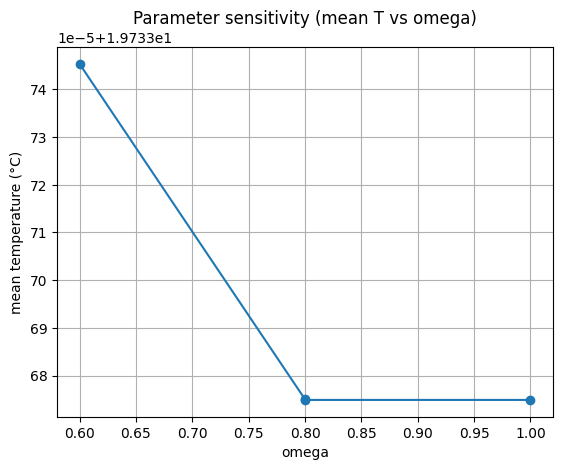

In [6]:
import os, subprocess, numpy as np

MAIN = os.path.join("main_for_task4.py")

def run_case(nproc, dx=None, iters=10, omega=0.8, heater_temp=None, new_apartment=False, outdir=None):
    cmd = [mpiexec, "-n", str(nproc), "python", MAIN,
           "--omega", str(omega),
           "--iters", str(iters)]
    if dx is not None:
        cmd += ["--dx", str(dx)]
    if heater_temp is not None:
        cmd += ["--heater-temp", str(heater_temp)]
    if new_apartment:
        cmd += ["--new-apartment"]
    if outdir is not None:
        os.makedirs(outdir, exist_ok=True)
    print("Running:", " ".join(cmd))
    subprocess.run(cmd, check=True)

    # 读取输出（旧公寓：output；新公寓：ext_output）
    out = "ext_output" if new_apartment else "output"
    u_files = ["u1.npy", "u2.npy", "u3.npy"] + (["u4.npy"] if new_apartment else [])
    U = []
    for f in u_files:
        path = os.path.join(PROJECT_ROOT, out, f)
        if os.path.exists(path):
            U.append(np.load(path))
    # 统计量（以全局平均温度为例；也可以改为接口残差）
    all_vals = np.concatenate([u[~np.isnan(u)].ravel() for u in U])
    return float(all_vals.mean())

# 扫描参数
configs = [
    dict(nproc=4, dx=0.05, iters=10, omega=0.6, heater_temp=40, new_apartment=False),
    dict(nproc=4, dx=0.05, iters=10, omega=0.8, heater_temp=40, new_apartment=False),
    dict(nproc=4, dx=0.05, iters=20, omega=0.8, heater_temp=40, new_apartment=False),
    dict(nproc=4, dx=0.05, iters=10, omega=1.0, heater_temp=40, new_apartment=False),
    # 也可以加入新公寓的对比
    # dict(nproc=5, dx=0.05, iters=10, omega=0.8, heater_temp=40, new_apartment=True),
]

records = []
for c in configs:
    meanT = run_case(**c)
    records.append((c["omega"], c["iters"], c["heater_temp"], c["dx"], c["nproc"], c["new_apartment"], meanT))
    print(f"ω={c['omega']}, K={c['iters']}, heater={c['heater_temp']}, dx={c['dx']}, procs={c['nproc']}, new={c['new_apartment']} -> meanT={meanT:.2f}°C")

# 画图（以 ω 为横轴举例）
import matplotlib.pyplot as plt
xs = [r[0] for r in records]   # omega
ys = [r[-1] for r in records]  # meanT
plt.plot(xs, ys, marker='o')
plt.xlabel('omega'); plt.ylabel('mean temperature (°C)')
plt.title('Parameter sensitivity (mean T vs omega)')
plt.grid(True)
plt.show()

## Project 3a：2.5 rooms

In [10]:
cmd = [mpiexec, "-n", "5", "python", f"main.py", "-n"]
subprocess.run(cmd, check=True)


Is the heating in the flat adequate?
1. Lowest temp:6.50 ˚C
2. Averaged temp:21.10˚C
3. Highest temp:39.59˚C
--------------------------------------------------
Averged tempture > 18˚C. The heating in the flat is adequate.

Saved figure: /Users/uljei/Documents/GitHub/Project_3/ext_output/room1.png
Saved figure: /Users/uljei/Documents/GitHub/Project_3/ext_output/room2.png
Saved figure: /Users/uljei/Documents/GitHub/Project_3/ext_output/room3.png
Saved figure: /Users/uljei/Documents/GitHub/Project_3/ext_output/room4.png


CompletedProcess(args=['/opt/homebrew/bin/mpiexec', '-n', '5', 'python', 'main.py', '-n'], returncode=0)